In [10]:
import tempfile
import matplotlib.pyplot as plt
import pydicom
#from pydicom.data import get_testdata_file
import cv2
import os
from skimage import morphology
import math
import numpy as np
from scipy import ndimage
from tqdm import tqdm
import glob as glob
import SimpleITK as sitk
import sys
#from pydicom.encaps import encapsulate
#from pydicom.uid import JPEG2000
#from pydicom.pixel_data_handlers.util import apply_modality_lut
from imagecodecs import jpeg_encode
import imagecodecs
import random
from pydicom.uid import ExplicitVRLittleEndian
from imagecodecs import jpeg_encode
import imagecodecs
import pylibjpeg


def sorted_files(folder):
    ins=[]
    ser=[]
    f= os.listdir(folder)
    for name in tqdm( f):
        itkimage = sitk.ReadImage(os.path.join(folder,name))
        temp= float(itkimage.GetMetaData('0020|0013')) # instance number 
        temp1= itkimage.GetMetaData('0020|000e') #series instance UID 
        ins.append(int(temp))
        ser.append(temp1)
    series=np.unique(ser)
    files=[[x for sr,_,x in sorted(zip(ser,ins,f)) if sr==s] for s in series]
    return files

def scan_func(path):
    f= sorted_files(path)
    series=[]
    files=[]
    for i in tqdm (range (len(f))):
        img=[]
        file=[]
        for filename in f[i]:
            itkimage = sitk.ReadImage(os.path.join(path,filename))
            numpyImage = sitk.GetArrayFromImage(itkimage)
            img.append(numpyImage[0,:,:])
            file.append(filename)
        series.append(img)
        files.append(file)
    return series,files




In [2]:
'''#path = input_folder="/home/abdullah/mri_fa/data_test/00093511"

#path = input_folder= r"C:\MRI_BRAIN_HEAD\MRI_BRAIN_data\00093511"
path =input_folder= r"C:\MRI_BRAIN_HEAD\MRI_BRAIN_data\00536351"
output_folder=r"C:\MRI_BRAIN_HEAD\MRI_BRAIN_result"
#output_folder= "/home/abdullah/mri_fa/00093511/MRI_BRAIN_result"
scan_series,filenames = scan_func(input_folder)
scan, names = scan_series[9],filenames[9]
scan=np.asarray(scan)
dcmData = pydicom.dcmread(os.path.join(path,names[0]))
'''

'#path = input_folder="/home/abdullah/mri_fa/data_test/00093511"\n\n#path = input_folder= r"C:\\MRI_BRAIN_HEAD\\MRI_BRAIN_data\x0093511"\npath =input_folder= r"C:\\MRI_BRAIN_HEAD\\MRI_BRAIN_data\x0536351"\noutput_folder=r"C:\\MRI_BRAIN_HEAD\\MRI_BRAIN_result"\n#output_folder= "/home/abdullah/mri_fa/00093511/MRI_BRAIN_result"\nscan_series,filenames = scan_func(input_folder)\nscan, names = scan_series[9],filenames[9]\nscan=np.asarray(scan)\ndcmData = pydicom.dcmread(os.path.join(path,names[0]))\n'

In [3]:
'''a = (np.around(dcmData.ImageOrientationPatient, 0))
print("a",a)
for i in range(scan.shape[0]):
    name = names[i]
    img = scan[i, :, :]
    dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
    r= dcmData.Rows
    c=dcmData.Columns
    
'''

'a = (np.around(dcmData.ImageOrientationPatient, 0))\nprint("a",a)\nfor i in range(scan.shape[0]):\n    name = names[i]\n    img = scan[i, :, :]\n    dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it\'s pixel data to anonymized\n    r= dcmData.Rows\n    c=dcmData.Columns\n    \n'

In [4]:
#scan.shape

In [5]:
'''dcmData = pydicom.dcmread(os.path.join(path,names[20])) ##read file to change it's pixel data to anonymized
rows= dcmData.Rows
colomns=dcmData.Columns
dicom_img=dcmData.pixel_array
plt.imshow(scan[20,:,:],'gray')
plt.show()
image= scan#[20,:,:]
histogram, bin_edges = np.histogram(image, bins=256)
histogram'''

"dcmData = pydicom.dcmread(os.path.join(path,names[20])) ##read file to change it's pixel data to anonymized\nrows= dcmData.Rows\ncolomns=dcmData.Columns\ndicom_img=dcmData.pixel_array\nplt.imshow(scan[20,:,:],'gray')\nplt.show()\nimage= scan#[20,:,:]\nhistogram, bin_edges = np.histogram(image, bins=256)\nhistogram"

In [6]:
#bin_edges[-1]

In [7]:
'''plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
#plt.xlim([-10.0, 1500.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram) '''

'plt.figure()\nplt.title("Grayscale Histogram")\nplt.xlabel("grayscale value")\nplt.ylabel("pixel count")\n#plt.xlim([-10.0, 1500.0])  # <- named arguments do not work here\n\nplt.plot(bin_edges[0:-1], histogram) '

## FUNCTION FOR SAGITTAL - MAIN

In [2]:

def MRI_blurred_sag(image,dicom_img, rows, columns):
    #if np.min(image) == np.min(dicom_img) and np.max(image) == np.max(dicom_img):
    #     print("equal")
    #else:
    #    image=dicom_img
    rows=image.shape[1]
    columns=image.shape[0]
    head = image>100
    skull = image>500
    ROI=np.logical_xor(head,skull)
    kernel = np.ones((30, 30), np.uint8)
    imagee = cv2.morphologyEx(ROI.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    imagee = ndimage.morphology.binary_fill_holes(imagee)
    imagee = imagee.astype(np.uint8)
    contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    gray = np.zeros_like(imagee)
    gray = cv2.drawContours(gray, contours,0, 255,1 )
    #plt.imshow(gray,'gray')
    #plt.show()
    temp=gray.copy()
    temp=np.where((temp==255),1,0)
    variable=int(temp.shape[1]/2)
    temp[:,variable:] = 0
    #plt.imshow(temp,'gray')
    #plt.show()
    #gray = np.where((gray==255), 0, 1)
    #gray[:,150:] = 0
    
    r=[[random.randint(-250,500) for i in range(rows)] for j in range(columns)]
    r=np.asarray(r)
    blurred_img= np.multiply(temp,r)
    out = np.where((temp==1), blurred_img, image)
   # if np.min(image) == np.min(dicom_img) and np.max(image) == np.max(dicom_img):
   #     out = np.where((temp==1), blurred_img, image)
   # else:
   #     out = np.where((temp==1), blurred_img, dicom_img)
    #out = np.where(skull>0,image,out)
    #plt.imshow(out,'gray')
    #plt.show()
    return out

## FUNCTION FOR AXIAL - MAIN

In [3]:

def MRI_blurred_axial(image,dicom_img, rows, columns):
    #if np.min(image) == np.min(dicom_img) and np.max(image) == np.max(dicom_img):
    #     print("equal")
    #else:
    #    image=dicom_img
    rows=image.shape[1]
    columns=image.shape[0]
    #print(rows,columns)
    #print(image.shape)
    head = image>100
    skull = image>500
    ROI=np.logical_xor(head,skull)
    kernel = np.ones((30, 30), np.uint8)
    imagee = cv2.morphologyEx(ROI.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    imagee = ndimage.morphology.binary_fill_holes(imagee)
    imagee = imagee.astype(np.uint8)
    contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    gray = np.zeros_like(imagee)
    gray = cv2.drawContours(gray, contours,0, 255,1 )
    #plt.imshow(gray,'gray')
    #plt.show()
    temp=gray.copy()
    temp=np.where((temp==255),1,0)
    variable=int((temp.shape[0])/2)
    temp[variable:,:] = 0
    #plt.imshow(temp,'gray')
    #plt.show()
    #gray = np.where((gray==255), 0, 1)
    #gray[:,150:] = 0
    #print(rows,columns)
    r=[[random.randint(-250,500) for i in range(rows)] for j in range(columns)]
    r=np.asarray(r)
    #print(r.shape)
    blurred_img= np.multiply(temp,r)
    out = np.where((temp==1), blurred_img, image)
   # if np.min(image) == np.min(dicom_img) and np.max(image) == np.max(dicom_img):
   #     out = np.where((temp==1), blurred_img, image)
   # else:
   #     out = np.where((temp==1), blurred_img, dicom_img)
    #out = np.where(skull>0,image,out)
    #plt.imshow(out,'gray')
    #plt.show()
    return out

## FUNCTION FOR CORONAL - MAIN

In [4]:

def MRI_blurred_coronal(image,dicom_img, rows, columns):
    #if np.min(image) == np.min(dicom_img) and np.max(image) == np.max(dicom_img):
    #     print("equal")
    #else:
    #    image=dicom_img
    rows=image.shape[1]
    columns=image.shape[0]
    #print(rows,columns)
    #print(image.shape)
    head = image>100
    skull = image>500
    ROI=np.logical_xor(head,skull)
    kernel = np.ones((30, 30), np.uint8)
    imagee = cv2.morphologyEx(ROI.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    imagee = ndimage.morphology.binary_fill_holes(imagee)
    imagee = imagee.astype(np.uint8)
    contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    gray = np.zeros_like(imagee)
    gray = cv2.drawContours(gray, contours,0, 255,1 )
    #plt.imshow(gray,'gray')
    #plt.show()
    temp=gray.copy()
    temp=np.where((temp==255),1,0)
    #plt.imshow(temp,'gray')
    #plt.show()
    #gray = np.where((gray==255), 0, 1)
    #gray[:,150:] = 0
   
    r=[[random.randint(-250,500) for i in range(rows)] for j in range(columns)]
    r=np.asarray(r)
    
    blurred_img= np.multiply(temp,r)
    out = np.where((temp==1), blurred_img, image)
   # if np.min(image) == np.min(dicom_img) and np.max(image) == np.max(dicom_img):
   #     out = np.where((temp==1), blurred_img, image)
   # else:
   #     out = np.where((temp==1), blurred_img, dicom_img)
    #out = np.where(skull>0,image,out)
    #plt.imshow(out,'gray')
    #plt.show()
    return out

### EXTRA ----

In [11]:
#out=MRI_blurred_axial(image,dicom_img ,rows, colomns)

In [12]:
'''np.unique(image)
#imagee = image>-50
head = image>100
skull = image>500
#skull = skull>1
ROI=np.logical_xor(head,skull)'''

'np.unique(image)\n#imagee = image>-50\nhead = image>100\nskull = image>500\n#skull = skull>1\nROI=np.logical_xor(head,skull)'

In [13]:

#plt.imshow(dcmData.pixel_array, 'gray')

In [14]:
#plt.imshow(ROI,'gray')

In [15]:
'''kernel = np.ones((30, 30), np.uint8)
imagee = cv2.morphologyEx(ROI.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
imagee = ndimage.morphology.binary_fill_holes(imagee)
imagee = imagee.astype(np.uint8)
plt.imshow(imagee,'gray')'''

"kernel = np.ones((30, 30), np.uint8)\nimagee = cv2.morphologyEx(ROI.astype(np.uint8), cv2.MORPH_CLOSE, kernel)\nimagee = ndimage.morphology.binary_fill_holes(imagee)\nimagee = imagee.astype(np.uint8)\nplt.imshow(imagee,'gray')"

In [16]:
'''contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
gray = np.zeros_like(imagee)
gray = cv2.drawContours(gray, contours,0, 255,2 )
plt.imshow(gray,'gray')
plt.show()


temp=gray.copy()
temp=np.where((temp==255),1,0)
print(temp.shape)
variable=int((temp.shape[0])/2)
temp[variable:,:] = 0
plt.imshow(temp,'gray')
plt.show()

#gray = np.where((gray==255), 0, 1)
#gray[:,150:] = 0
print(temp.shape)
colomns=temp.shape[0]
rows=temp.shape[1]
r=[[random.randint(-250,500) for i in range(rows)] for j in range(colomns)]
r=np.asarray(r)
blurred_img= np.multiply(temp,r)
out = np.where((temp==1), blurred_img, image)
#out = np.where(skull>0,image,out)
plt.imshow(out,'gray')
plt.show()






'''

"contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)\ngray = np.zeros_like(imagee)\ngray = cv2.drawContours(gray, contours,0, 255,2 )\nplt.imshow(gray,'gray')\nplt.show()\n\n\ntemp=gray.copy()\ntemp=np.where((temp==255),1,0)\nprint(temp.shape)\nvariable=int((temp.shape[0])/2)\ntemp[variable:,:] = 0\nplt.imshow(temp,'gray')\nplt.show()\n\n#gray = np.where((gray==255), 0, 1)\n#gray[:,150:] = 0\nprint(temp.shape)\ncolomns=temp.shape[0]\nrows=temp.shape[1]\nr=[[random.randint(-250,500) for i in range(rows)] for j in range(colomns)]\nr=np.asarray(r)\nblurred_img= np.multiply(temp,r)\nout = np.where((temp==1), blurred_img, image)\n#out = np.where(skull>0,image,out)\nplt.imshow(out,'gray')\nplt.show()\n\n\n\n\n\n\n"

### EXTRA ENDS ---

## MAIN FUNCTION CALLING 

In [5]:
from skimage.metrics import structural_similarity

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [6]:
def get_imgs_score(scani_series,filenamesi, opath):
#     scani_series,filenamesi = scan_func(ipath)
    scano_series,filenameso = scan_func(opath)
#     pscan, n = get_full_scan(ppath) 
    error=[]
    for j in range(len(scani_series)):#tqdm(range(len(scani_series))):
        iscan = scani_series[j]
        iscan = np.asarray(iscan)
        name = filenamesi[j]
        n = name[0]
        ds = pydicom.dcmread(os.path.join(ipath+n))
        oscan = scano_series[j]
        oscan = np.asarray(oscan)   
#         if ds.PhotometricInterpretation != "RGB":
        try:
            print("series number: ",j)
            i = int(iscan.shape[0]/2)
            print(i)
            plt.imshow(iscan[i],'gray')
            plt.title("input")
            plt.show()
        #     plt.imshow(pscan[i],'gray')
        #     plt.show()
            plt.imshow(oscan[i],'gray')
            plt.title("output")
            plt.show()   

            snri = signaltonoise(iscan, axis=None, ddof=0)
            snro = signaltonoise(oscan, axis=None, ddof=0)
            print(snri, snro)
            score,diff = structural_similarity(iscan, oscan, full=True)
            
            print(score) 
        except Exception as e:
            error.append((j,e))
    return error

In [ ]:
    #path = input_folder="/home/abdullah/mri_fa/data_test/00093511"
    #output = output_folder= "/home/abdullah/mri_fa/00093511/MRI_BRAIN_result"
    #path = input_folder= r"C:\MRI_BRAIN_HEAD\MRI_BRAIN_data\00093511"
#     path = input_folder= r"C:\MRI_BRAIN_HEAD\MRI_HEAD_data\00241178"

#     output = output_folder=r"C:\MRI_BRAIN_HEAD\head_results\00241178"
 

In [7]:
 
def main(path, output):
    if not os.path.exists(output):
        os.makedirs(output)
        
    scan_series,filenames = scan_func(path)
    #scan_series,filenames = scan_func(path)

    for j in tqdm(range(len(scan_series))):
        scan, names = scan_series[j],filenames[j]
        scan=np.asarray(scan)
        dcmData = pydicom.dcmread(os.path.join(path,names[0]))

        axial  =  np.array([1., 0., 0., 0., 1., 0.])
        #sagittal= np.array([-1., 0., 0., 0., 0., -1.])
        sagittal= np.array([0., 1., 0., 0., 0., -1.])
        coronal= np.array([1., 0., 0., 0., 0., -1.])
        if (0x0020,0x0037) in dcmData:
            a = (np.around(dcmData.ImageOrientationPatient, 0))
#             print("a",a)
#             print("scan shape",scan.shape[0])
            image= scan#[20,:,:]
            histogram, bin_edges = np.histogram(image, bins=256)
            check=bin_edges[-1]



            if ((a == axial).all()) and check>1000 :
#                 print("axial")
#                 print(j)
                #continue
                for i in range(scan.shape[0]):
                    name = names[i]
                    img = scan[i, :, :]
                    dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                    c= dcmData.Rows
                    r=dcmData.Columns
                    dicom_img = dcmData.pixel_array
                    out= MRI_blurred_axial(img,dicom_img,r,c)
                    #out = out.astype(np.int16)
                    #print(dicom_img.dtype)
                    out1 = out.astype(dicom_img.dtype)
                    #print(out.shape)
                    dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                    dcmData.PixelData = out1.tobytes()
                    '''
                    plt.imshow(dcmData.pixel_array,'gray')
                    plt.title("axial blurred")
                    plt.show()

                    plt.imshow(out, 'gray')
                    plt.title("axial blurred OUT")
                    plt.show()
                    '''
                    des_path = os.path.join(output, name)
                    dcmData.save_as(des_path) ##save file in anonym folder


                    #classUID.append(str(dcmData.SOPClassUID))
                    #output_list.append(des_path)

            elif ((a==sagittal).all()) and check>1000:
#                     print(j)
#                     print("sag")
                   # continue
                    for i in range(scan.shape[0]):
                        name = names[i]
                        img = scan[i, :, :]
                        dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                        #print(dcmData.file_meta.TransferSyntaxUID)
                        dicom_img = dcmData.pixel_array
                        r= dcmData.Rows
                        c=dcmData.Columns
                        if i == 0:
                            out = img
                        else:
                            out = MRI_blurred_sag(img,dicom_img,r,c)
                        #out = out.astype(np.int16)
                        out = out.astype(dicom_img.dtype)
                        #plt.imshow(out,'gray')
                        #plt.show()

                        dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                        #dcmData.pixel_array = out
                        dcmData.PixelData = out.tobytes()
                        #dcmData.PixelData = out.tostring()
                        #dcmData.BitsAllocated = 
                        #dcmData.PixelRepresentation = 1
                        '''
                        plt.imshow(dcmData.pixel_array,'gray')
                        plt.title("sagittal blurred")
                        plt.show()

                        plt.imshow(out, 'gray')
                        plt.title("sagittal blurred OUT")
                        plt.show()
                        '''
                        des_path = os.path.join(output, name)
                        dcmData.save_as(des_path) ##save file in anonym folder

                        #classUID.append(str(dcmData.SOPClassUID))
                        #output_list.append(des_path)
            elif ((a==coronal).all()) and (scan.shape[0]>100) and  check>1000:
#                     print(j)
#                     scan.shape[0]
#                     print("coronal")
                    #continue

                    for i in range(scan.shape[0]):
#                     for i in range(50): #distorting the boundary for only the front of the coronal scan i.e the face part
                        if i<50:
                            name = names[i]
                            img = scan[i, :, :]
                            dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                            #print(dcmData.file_meta.TransferSyntaxUID)
                            dicom_img = dcmData.pixel_array
                            r= dcmData.Rows
                            c=dcmData.Columns
                            if i == 0:
                                out = img
                            else:
                                out = MRI_blurred_coronal(img,dicom_img,r,c)
                            #out = out.astype(np.int16)
                            out = out.astype(dicom_img.dtype)
                            #plt.imshow(out,'gray')
                            #plt.show()

                            dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                            #dcmData.file_meta.TransferSyntaxUID= 'Explicit VR Big Endian'
                            #dcmData.pixel_array = out
                            dcmData.PixelData = out.tobytes()
                            #dcmData.PixelData = out.tostring()

                            '''
                            plt.imshow(dcmData.pixel_array,'gray')
                            plt.title("coronal blurred")
                            plt.show()

                            plt.imshow(out, 'gray')
                            plt.title("coronal blurred OUT")
                            plt.show()
                            ''' 
                            des_path = os.path.join(output, name)
                            dcmData.save_as(des_path) ##save file in anonym folder

                            #classUID.append(str(dcmData.SOPClassUID))
                            #output_list.append(des_path)
                        else:
                            name = names[i]
                            img = scan[i, :, :]
                            dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                            #print(dcmData.file_meta.TransferSyntaxUID)

                            dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                            #dcmData.file_meta.TransferSyntaxUID= 'Explicit VR Big Endian'
                            #dcmData.pixel_array = out
                            #dcmData.PixelData = out.tostring()

                            '''
                            plt.imshow(dcmData.pixel_array,'gray')
                            plt.title("coronal blurred")
                            plt.show()

                            plt.imshow(out, 'gray')
                            plt.title("coronal blurred OUT")
                            plt.show()
                            ''' 
                            des_path = os.path.join(output, name)
                            dcmData.save_as(des_path) ##save file in anonym folder

                            #classUID.append(str(dcmData.SOPClassUID))
                            #output_list.append(des_path)
            else:
                    #print("ccc")
                    #continue
                    for i in range(scan.shape[0]):
                        #print(scan.shape[0],i)
                        name = names[i]
                        #print("name",name)
                        img = scan[i, :, :]
                        dcmData = pydicom.dcmread(os.path.join(path,name))
                        des_path = os.path.join(output, name)
                        dcmData.save_as(des_path) ##save file in anonym folder
                        #classUID.append(str(dcmData.SOPClassUID))
                        #output_list.append(des_path)
        else:
            for i in range(scan.shape[0]):
                name = names[i]
                img = scan[i, :, :]
                dcmData = pydicom.dcmread(os.path.join(path,name)) 
                des_path = os.path.join(output, name)
                dcmData.save_as(des_path) 
                #classUID.append(str(dcmData.SOPClassUID))
                #output_list.append(des_path)
                
    return scan_series,filenames

In [8]:
ipath = r"/home/abdullah/mri_fa/MRI_DATA_HB/brain/20392703/" #20392703
opath = r"/home/minha/FARZEEN/face ann/face mri/output_brain/20392703/"
scan_seriesi, filenamesi = main(ipath, opath)

  0%|                                                    | 0/26 [00:00<?, ?it/s]/tmp/ipykernel_21625/2150677952.py:15: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  imagee = ndimage.morphology.binary_fill_holes(imagee)
 19%|████████▍                                   | 5/26 [00:09<00:32,  1.55s/it]/tmp/ipykernel_21625/2920841642.py:13: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  imagee = ndimage.morphology.binary_fill_holes(imagee)
100%|███████████████████████████████████████████| 26/26 [04:45<00:00, 10.97s/it]


  0%|                                                    | 0/26 [00:00<?, ?it/s]

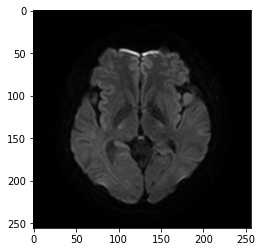

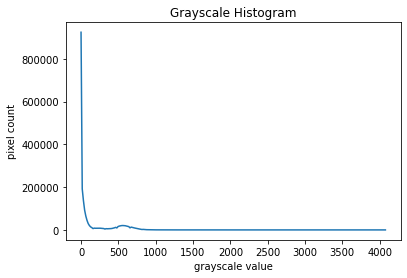

  4%|█▋                                          | 1/26 [00:00<00:05,  4.27it/s]

series:  0
4094.0


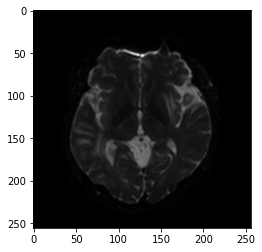

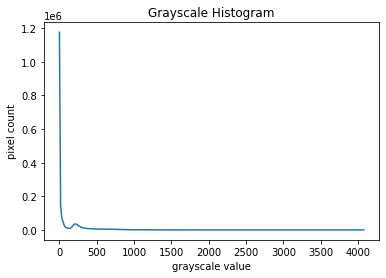

  8%|███▍                                        | 2/26 [00:00<00:05,  4.76it/s]

series:  1
4094.0


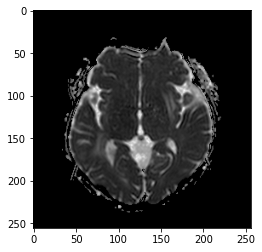

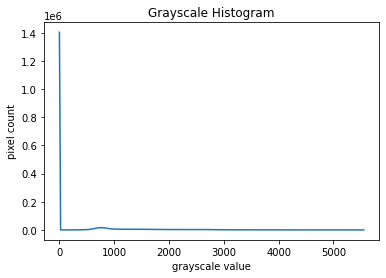

 12%|█████                                       | 3/26 [00:00<00:04,  4.79it/s]

series:  2
5576.161039309087


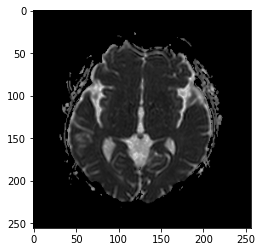

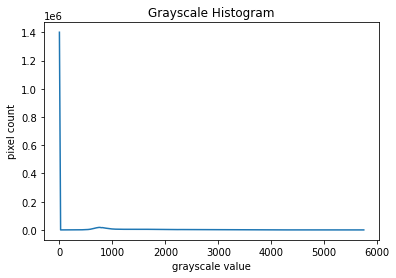

 15%|██████▊                                     | 4/26 [00:00<00:04,  4.91it/s]

series:  3
5770.739435996679


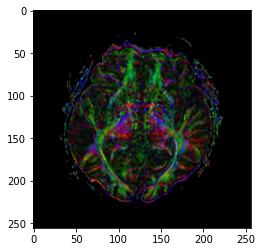

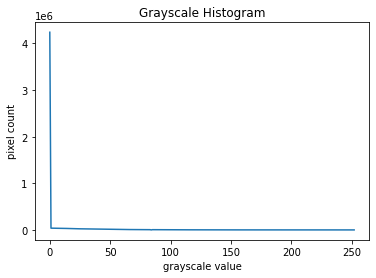

 19%|████████▍                                   | 5/26 [00:01<00:04,  4.42it/s]

series:  4
253.0


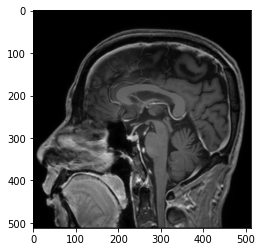

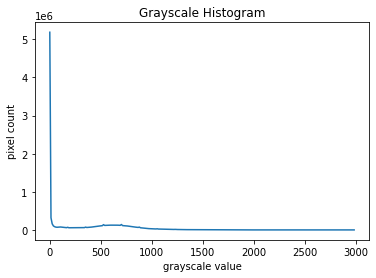

 23%|██████████▏                                 | 6/26 [00:01<00:06,  3.17it/s]

series:  5
2992.443467643458


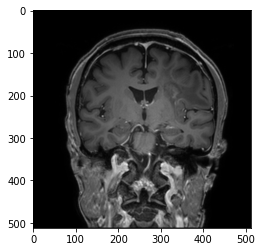

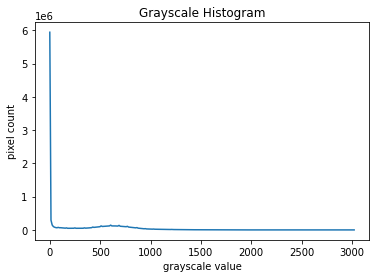

 27%|███████████▊                                | 7/26 [00:01<00:06,  2.97it/s]

series:  6
3033.9731379731284


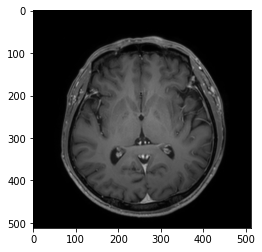

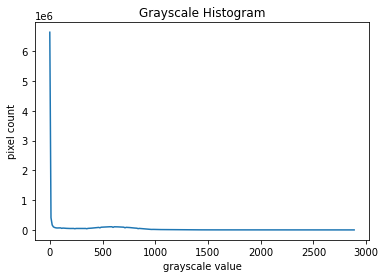

 31%|█████████████▌                              | 8/26 [00:02<00:06,  2.83it/s]

series:  7
2897.8481074480983


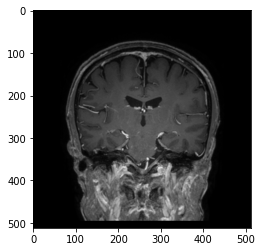

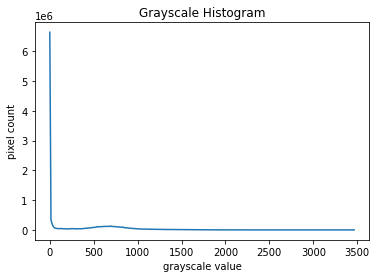

 35%|███████████████▏                            | 9/26 [00:02<00:06,  2.77it/s]

series:  8
3479.181196581183


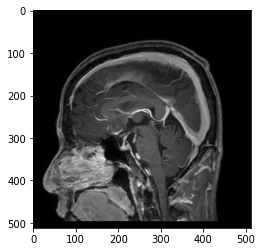

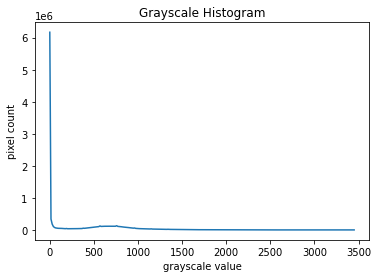

 38%|████████████████▌                          | 10/26 [00:03<00:05,  2.76it/s]

series:  9
3463.5794871794733


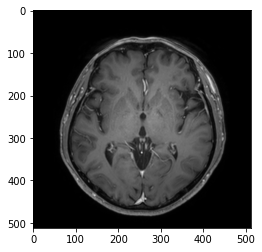

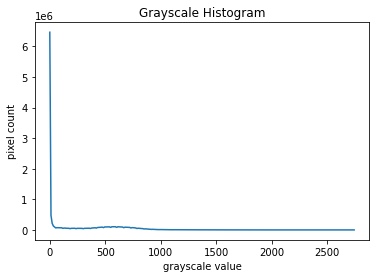

 42%|██████████████████▏                        | 11/26 [00:03<00:05,  2.78it/s]

series:  10
2752.5873015872908


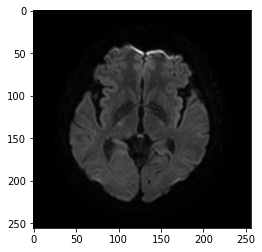

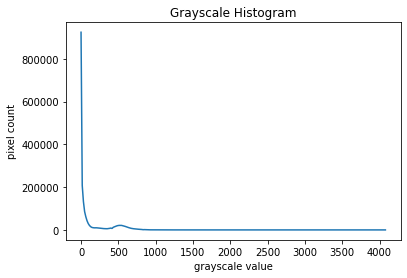

 46%|███████████████████▊                       | 12/26 [00:03<00:04,  3.04it/s]

series:  11
4095.0


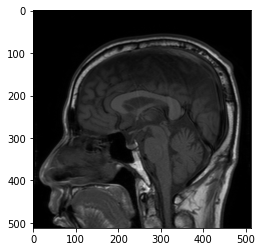

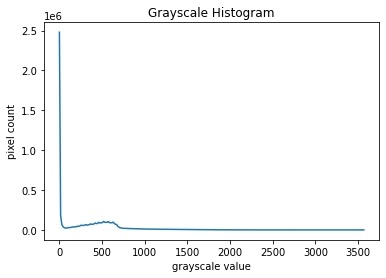

 50%|█████████████████████▌                     | 13/26 [00:03<00:04,  3.20it/s]

series:  12
3582.4732600732536


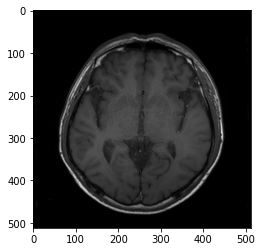

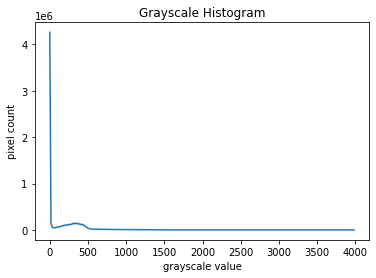

 54%|███████████████████████▏                   | 14/26 [00:04<00:03,  3.24it/s]

series:  13
3999.7816849816836


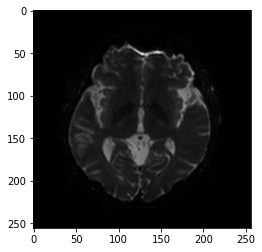

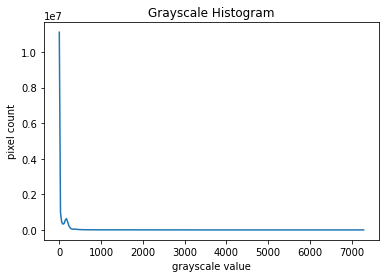

 58%|████████████████████████▊                  | 15/26 [00:04<00:03,  2.96it/s]

series:  14
7313.9999999999745


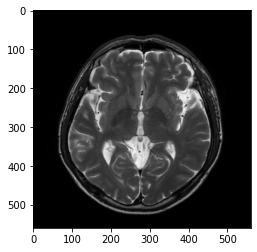

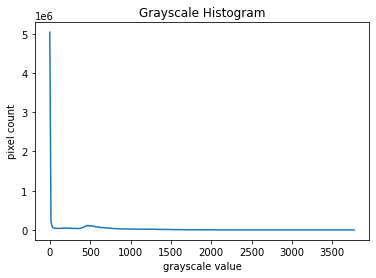

 62%|██████████████████████████▍                | 16/26 [00:05<00:03,  3.02it/s]

series:  15
3785.599999999998


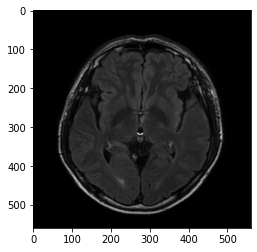

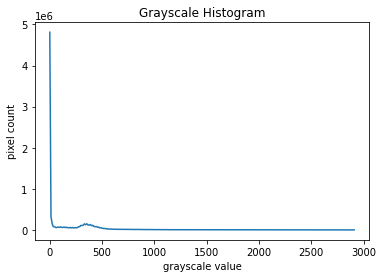

 65%|████████████████████████████               | 17/26 [00:05<00:02,  3.12it/s]

series:  16
2920.8449328449205


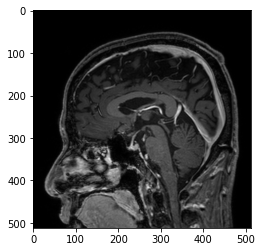

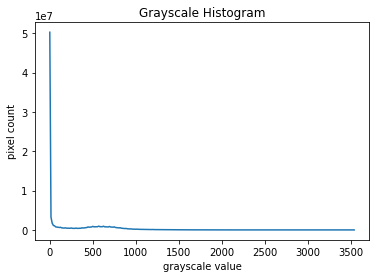

 69%|█████████████████████████████▊             | 18/26 [00:06<00:05,  1.37it/s]

series:  17
3548.274481074467


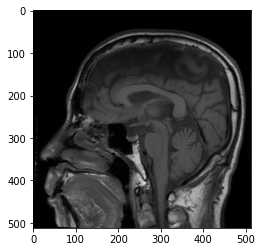

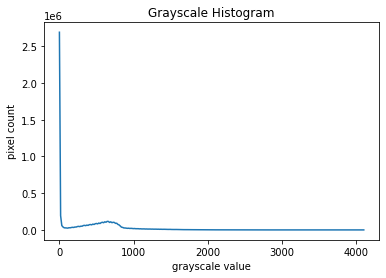

 73%|███████████████████████████████▍           | 19/26 [00:07<00:04,  1.61it/s]

series:  18
4121.50821


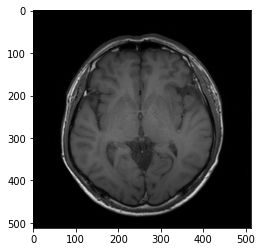

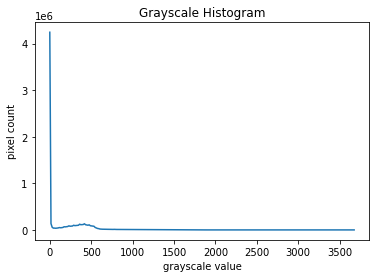

 77%|█████████████████████████████████          | 20/26 [00:07<00:03,  1.89it/s]

series:  19
3689.2581450000002


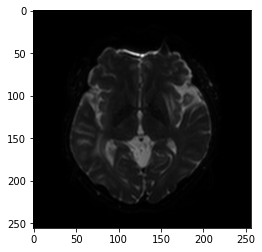

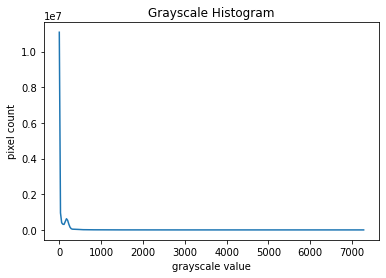

 81%|██████████████████████████████████▋        | 21/26 [00:08<00:02,  2.01it/s]

series:  20
7305.000885


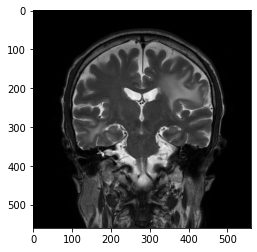

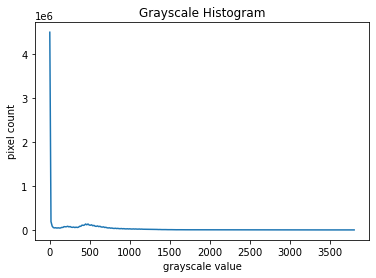

 85%|████████████████████████████████████▍      | 22/26 [00:08<00:01,  2.24it/s]

series:  21
3813.59979


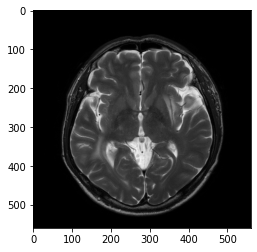

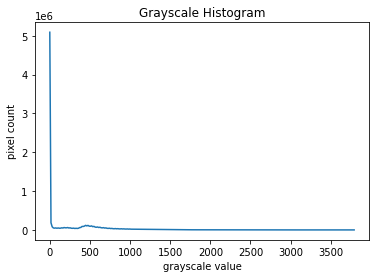

 88%|██████████████████████████████████████     | 23/26 [00:08<00:01,  2.40it/s]

series:  22
3806.800452


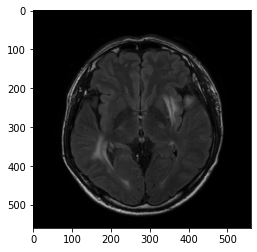

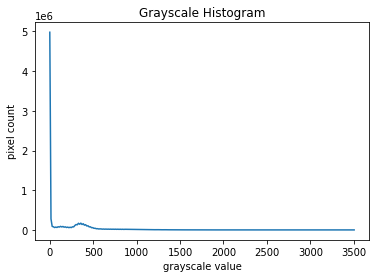

 92%|███████████████████████████████████████▋   | 24/26 [00:09<00:00,  2.59it/s]

series:  23
3518.5982905982787


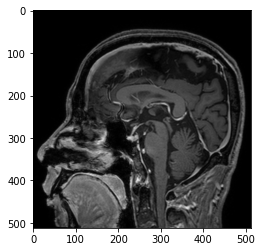

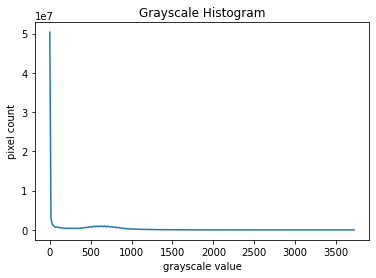

 96%|█████████████████████████████████████████▎ | 25/26 [00:10<00:00,  1.28it/s]

series:  24
3735.363125763114


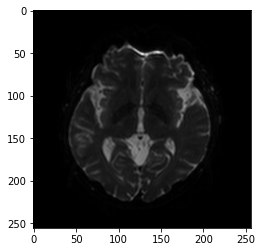

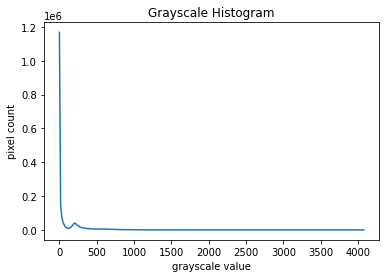

100%|███████████████████████████████████████████| 26/26 [00:10<00:00,  2.37it/s]

series:  25
4095.0


In [9]:
for j in tqdm(range(len(scan_seriesi))):
    scan, names = scan_seriesi[j],filenamesi[j]
    scan=np.asarray(scan)
    dcmData = pydicom.dcmread(os.path.join(ipath,names[int(scan.shape[0]/2)]))
    plt.imshow(dcmData.pixel_array,'gray')
    plt.show()
    image= scan#[20,:,:]
    histogram, bin_edges = np.histogram(image, bins=256)
    check=bin_edges[-1]

    plt.figure()
    plt.title("Grayscale Histogram")
    plt.xlabel("grayscale value")
    plt.ylabel("pixel count")
    #plt.xlim([-10.0, 1500.0])  # <- named arguments do not work here

    plt.plot(bin_edges[0:-1], histogram)
    plt.show()
    print("series: ", j)
    print(check)


100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]


series number:  0
26


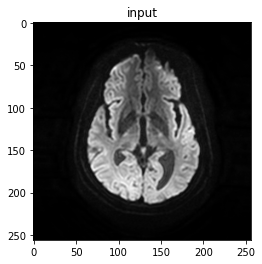

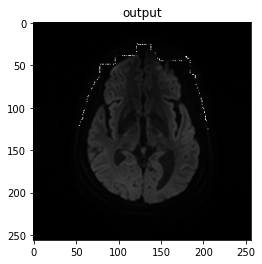

0.5022255760894684 0.441377665082639
0.9936357222673803
series number:  1
102


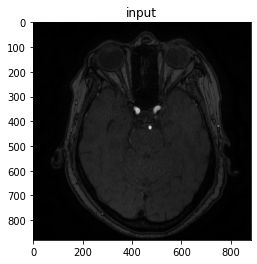

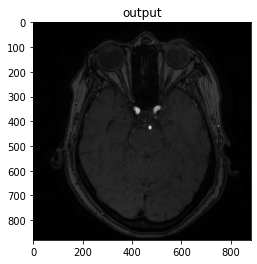

0.946013942984981 0.946013942984981
1.0
series number:  2
12


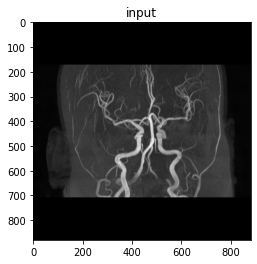

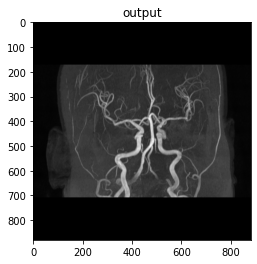

0.9012443237223506 0.9012443237223506
1.0
series number:  3
12


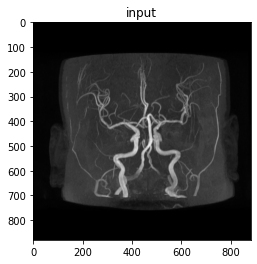

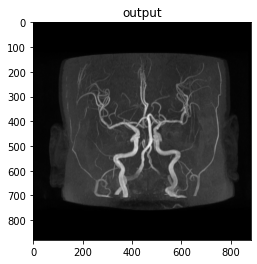

1.134838482749207 1.134838482749207
1.0
series number:  4
26


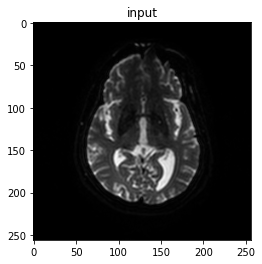

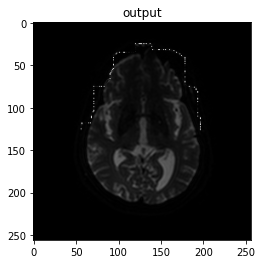

0.40662223325357394 0.3584342703336165
0.9945866803412808
series number:  5
26


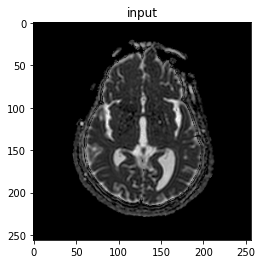

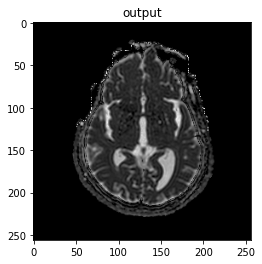

0.49473981457400273 0.4876702252936957
0.9947851935177875


[]

In [75]:
get_imgs_score(scan_seriesi, filenamesi, opath)

In [11]:
import copy
def get_normalized(scan,mn,mx):
    print("here")
    scann = copy.copy(scan)
    mn = max(mn,np.amin(scann))
    mx = min(mx,np.amax(scann))
    np.clip(scann, mn, mx, out=scann)
    d = mx - mn
    scann = (scann-mn)/d
    return scann

def dynamic_windowing(scan):
    counts,bins,bars = plt.hist(scan.flatten())
    print(bins[-1])
    plt.close()
    if bins[-1]>3200:
        a  = 2
        print("Type 2")
        scan = get_normalized(scan, -800, 2500)
    elif bins[-1]>350:
        a = 3
        print("Type 3")
        scan = get_normalized(scan, 5, 100)
    else:
        scan = scan
        a = 1
    return scan,a

***************  0


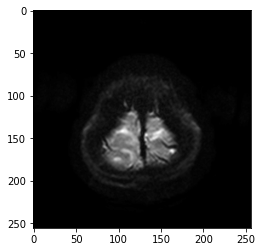

4094.0
Type 2
here


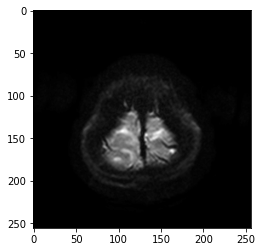

***************  1


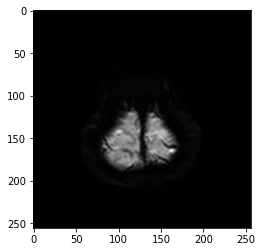

4094.0
Type 2
here


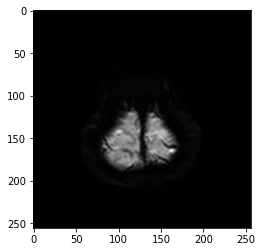

***************  2


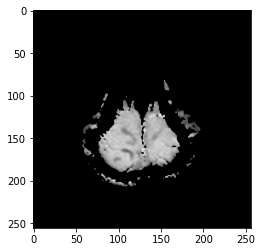

5576.161039309087
Type 2
here


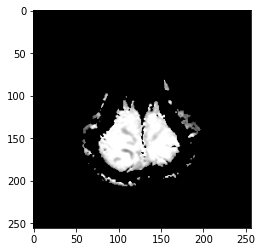

***************  3


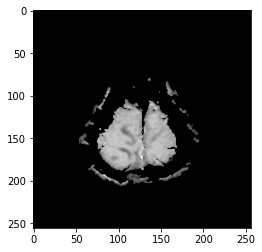

5770.739435996679
Type 2
here


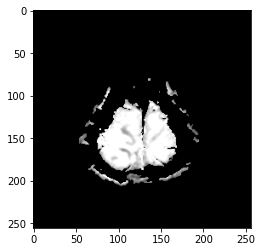

***************  4


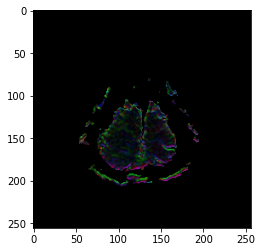

253.0


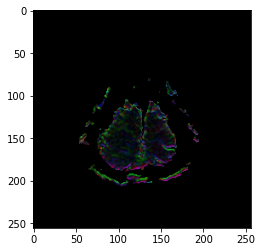

***************  5


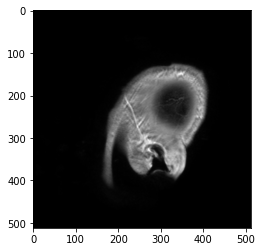

2992.443467643458
Type 3
here


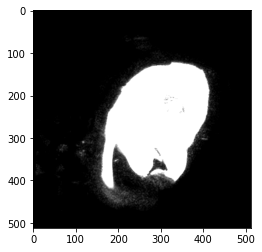

***************  6


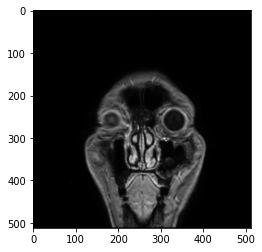

3033.9731379731284
Type 3
here


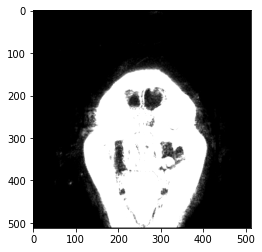

***************  7


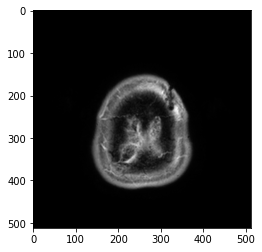

2897.8481074480983
Type 3
here


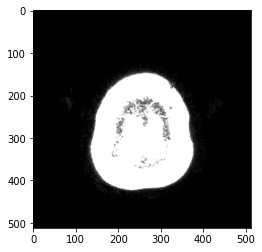

***************  8


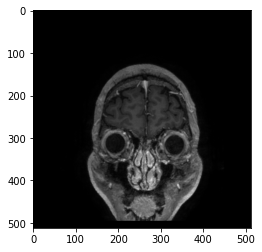

3479.181196581183
Type 2
here


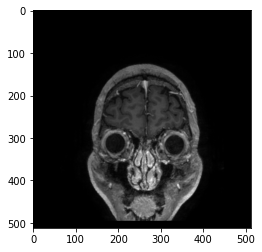

***************  9


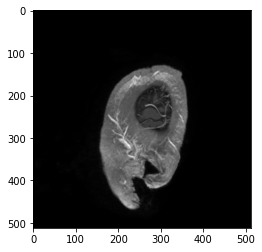

3463.5794871794733
Type 2
here


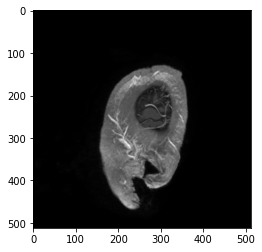

***************  10


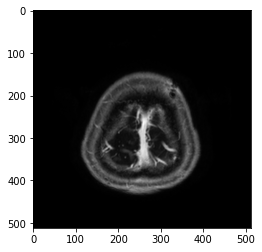

2752.5873015872908
Type 3
here


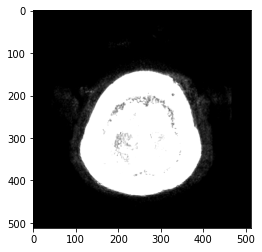

***************  11


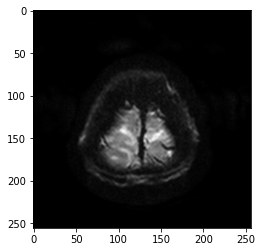

4095.0
Type 2
here


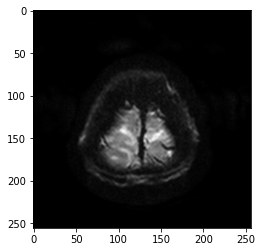

***************  12


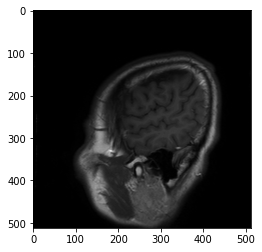

3582.4732600732536
Type 2
here


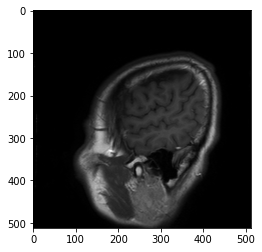

***************  13


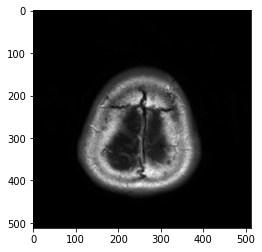

3999.7816849816836
Type 2
here


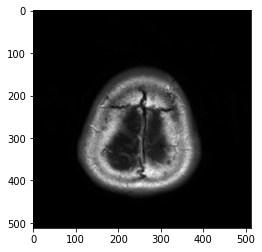

***************  14


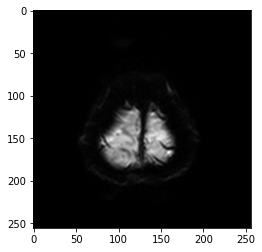

7313.9999999999745
Type 2
here


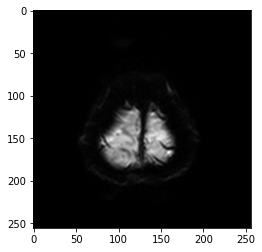

***************  15


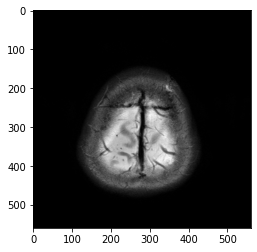

3785.599999999998
Type 2
here


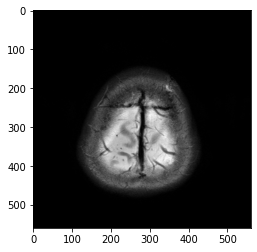

***************  16


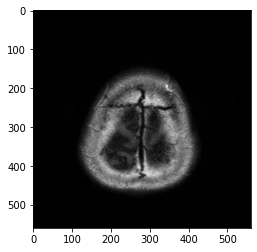

2920.8449328449205
Type 3
here


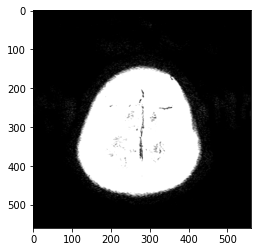

***************  17


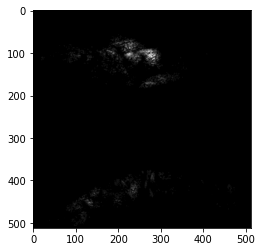

3548.274481074467
Type 2
here


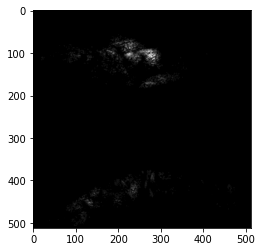

***************  18


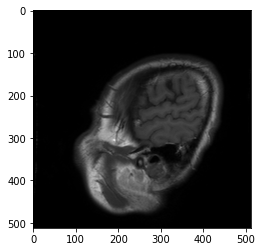

4121.50821
Type 2
here


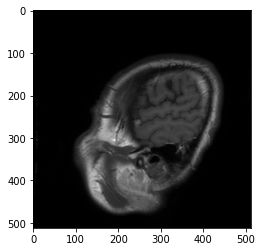

***************  19


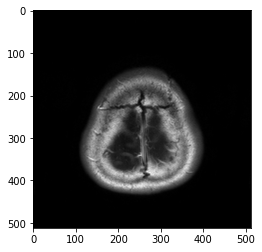

3689.2581450000002
Type 2
here


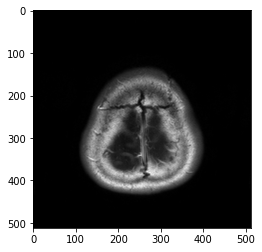

***************  20


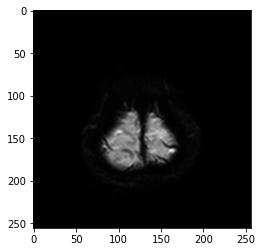

7305.000885
Type 2
here


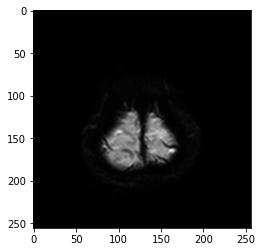

***************  21


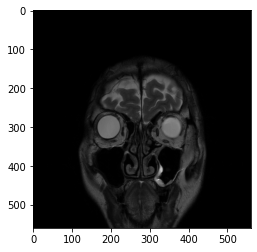

3813.59979
Type 2
here


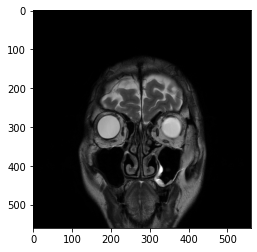

***************  22


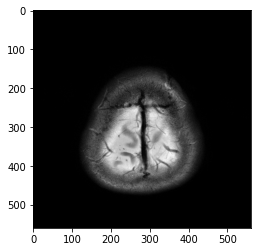

3806.800452
Type 2
here


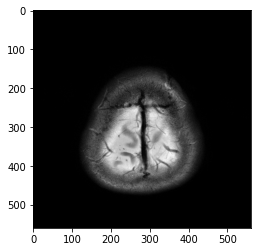

***************  23


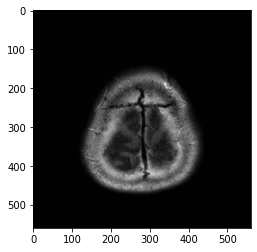

3518.5982905982787
Type 2
here


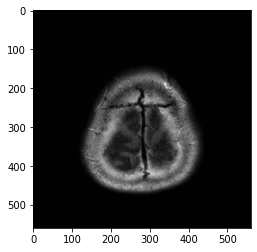

***************  24


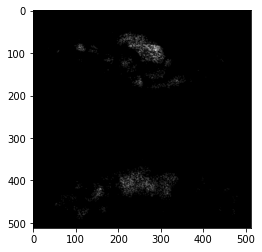

3735.363125763114
Type 2
here


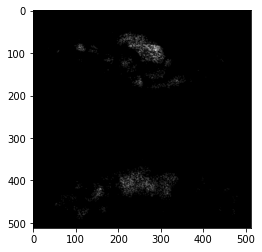

***************  25


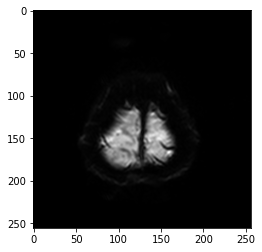

4095.0
Type 2
here


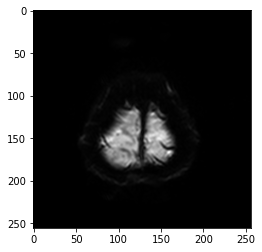

In [15]:
for i in range(len(scan_seriesi)):
    print("*************** ",i)
    scan = np.asarray(scan_seriesi[i])
#     counts,bins,bars = plt.hist(scan.flatten())
#     print("for ",i," bins max: ", bins[-1])
    plt.imshow(scan[0],'gray')
    plt.show()
    s,a = dynamic_windowing(scan)
    plt.imshow(s[0],'gray')
#     plt.title("FOR SERIES "+str(i))
    plt.show()

In [69]:
def MRI_blurred_axial(image, scan_img):
    #if np.min(image) == np.min(dicom_img) and np.max(image) == np.max(dicom_img):
    #     print("equal")
    #else:
    #    image=dicom_img
    rows=image.shape[1]
    columns=image.shape[0]
    #print(rows,columns)
    #print(image.shape)
    head = image > 100
    skull = image > 1000
    ROI=np.logical_xor(head,skull)
    kernel = np.ones((30, 30), np.uint8)
    imagee = cv2.morphologyEx(ROI.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
#     plt.imshow(imagee,'gray')
#     plt.title("morphologyEx")
#     plt.show()
    imagee = ndimage.morphology.binary_fill_holes(imagee)
    imagee = imagee.astype(np.uint8)
#     plt.imshow(imagee,'gray')
#     plt.title("fill holes")
#     plt.show()
    contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    gray = np.zeros_like(imagee)
#     plt.imshow(gray,'gray')
#     plt.title("zeros like imagee")
#     plt.show()
    gray = cv2.drawContours(gray, contours,0, 255,2 )
    plt.imshow(gray,'gray')
    plt.show()
    temp=gray.copy()
    temp=np.where((temp==255),1,0)
    variable=int((temp.shape[0])/2)
    temp[variable:,:] = 0
#     plt.imshow(temp,'gray')
#     plt.title("temp")
#     plt.show()
    #gray = np.where((gray==255), 0, 1)
    #gray[:,150:] = 0
    #print(rows,columns)
    r=[[random.randint(-250,500) for i in range(rows)] for j in range(columns)]
    r=np.asarray(r)
    #print(r.shape)
    blurred_img= np.multiply(temp,r)
    print(temp.shape)
    print(blurred_img.shape)
    print(scan_img.shape)
    out = np.where((temp==1), blurred_img, scan_img)
   # if np.min(image) == np.min(dicom_img) and np.max(image) == np.max(dicom_img):
   #     out = np.where((temp==1), blurred_img, image)
   # else:
   #     out = np.where((temp==1), blurred_img, dicom_img)
    #out = np.where(skull>0,image,out)
    #plt.imshow(out,'gray')
    #plt.show()
    return out

In [37]:
scan7[0].shape

(512, 512)

In [38]:
s7[0][0].shape

(512, 512)

3463.5794871794733
Type 2
here
*************  0


/tmp/ipykernel_21625/156736730.py:18: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  imagee = ndimage.morphology.binary_fill_holes(imagee)


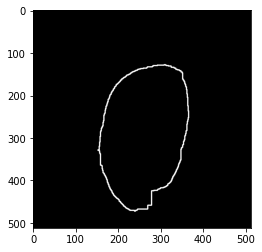

(512, 512)
(512, 512)
(512, 512)


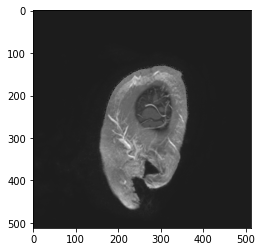

*************  1


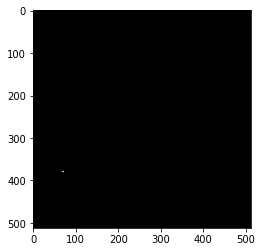

(512, 512)
(512, 512)
(512, 512)


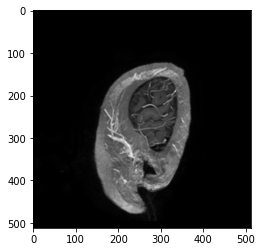

*************  2


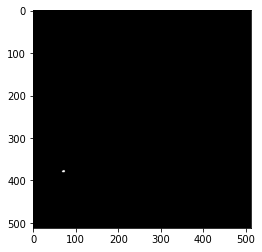

(512, 512)
(512, 512)
(512, 512)


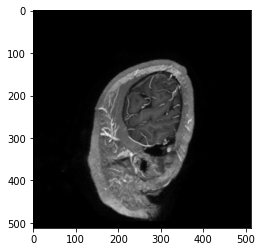

*************  3


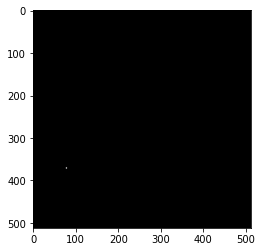

(512, 512)
(512, 512)
(512, 512)


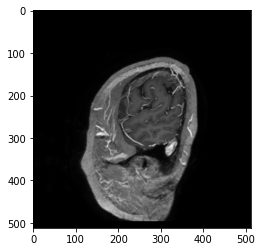

*************  4


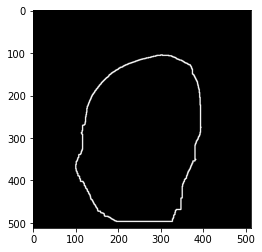

(512, 512)
(512, 512)
(512, 512)


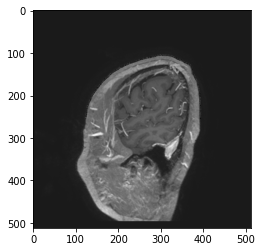

*************  5


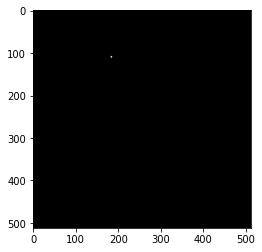

(512, 512)
(512, 512)
(512, 512)


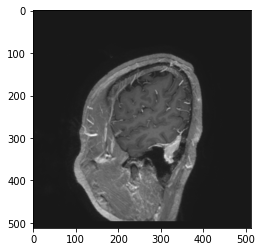

*************  6


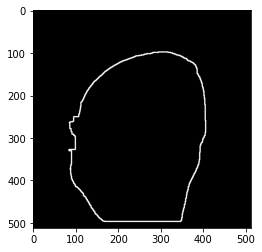

(512, 512)
(512, 512)
(512, 512)


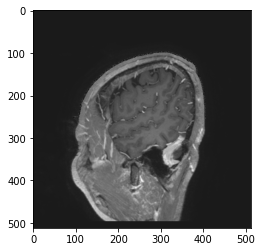

*************  7


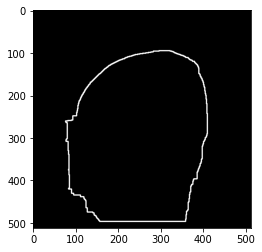

(512, 512)
(512, 512)
(512, 512)


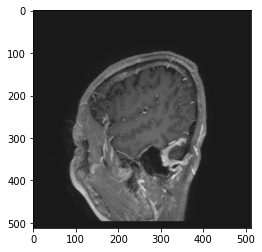

*************  8


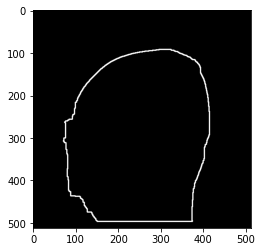

(512, 512)
(512, 512)
(512, 512)


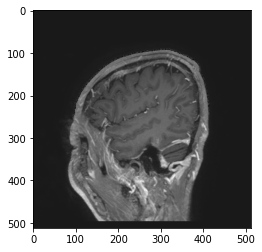

*************  9


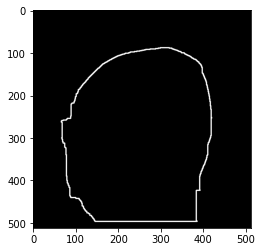

(512, 512)
(512, 512)
(512, 512)


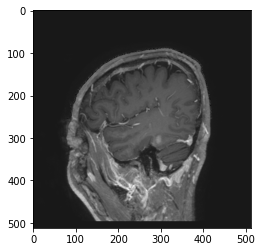

*************  10


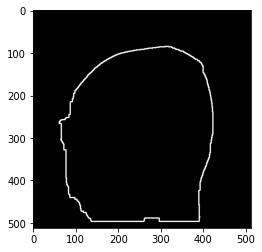

(512, 512)
(512, 512)
(512, 512)


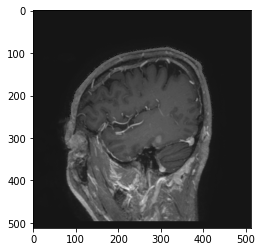

*************  11


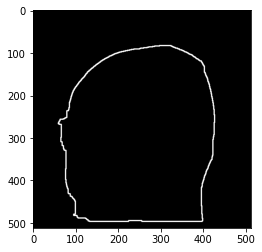

(512, 512)
(512, 512)
(512, 512)


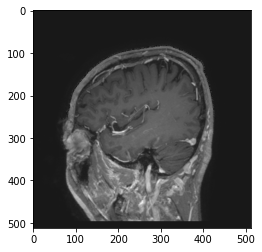

*************  12


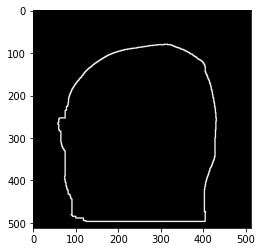

(512, 512)
(512, 512)
(512, 512)


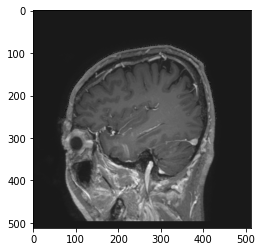

*************  13


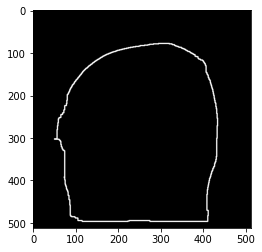

(512, 512)
(512, 512)
(512, 512)


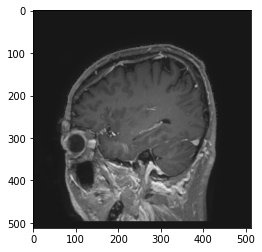

*************  14


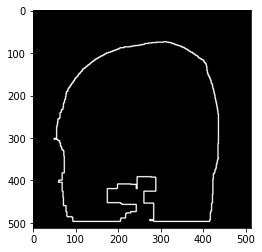

(512, 512)
(512, 512)
(512, 512)


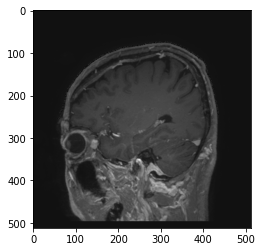

*************  15


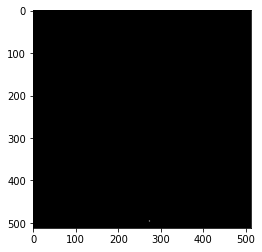

(512, 512)
(512, 512)
(512, 512)


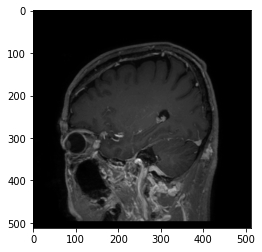

*************  16


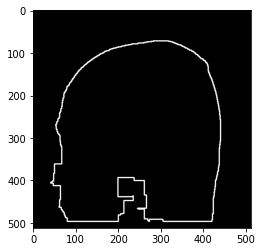

(512, 512)
(512, 512)
(512, 512)


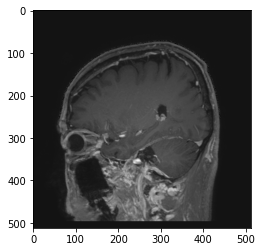

*************  17


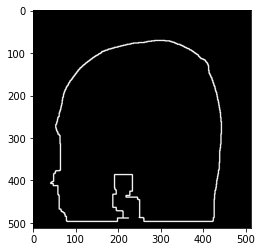

(512, 512)
(512, 512)
(512, 512)


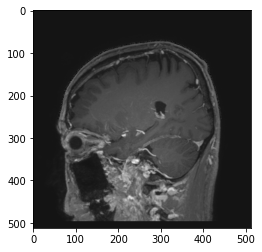

*************  18


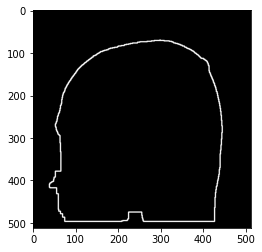

(512, 512)
(512, 512)
(512, 512)


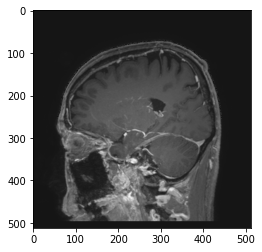

*************  19


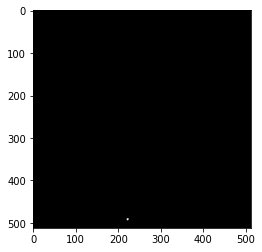

(512, 512)
(512, 512)
(512, 512)


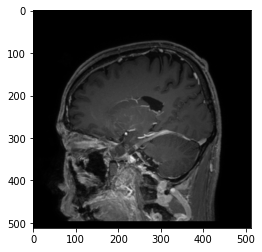

*************  20


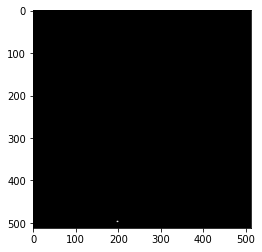

(512, 512)
(512, 512)
(512, 512)


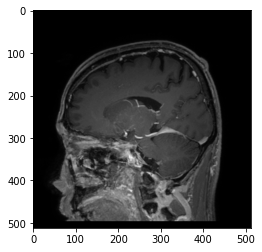

*************  21


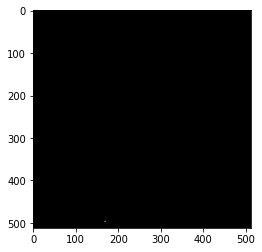

(512, 512)
(512, 512)
(512, 512)


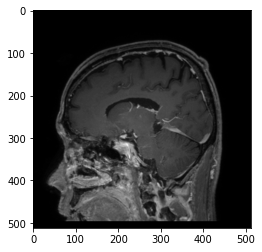

*************  22


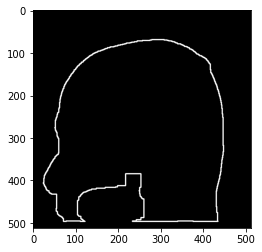

(512, 512)
(512, 512)
(512, 512)


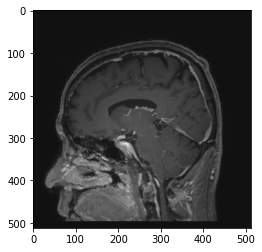

*************  23


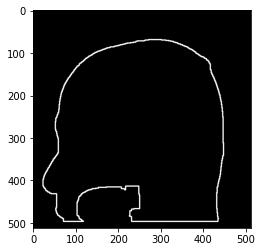

(512, 512)
(512, 512)
(512, 512)


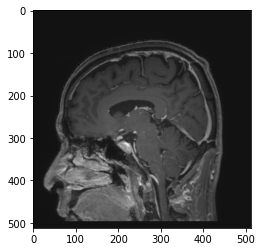

*************  24


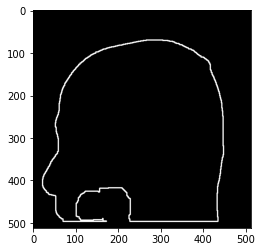

(512, 512)
(512, 512)
(512, 512)


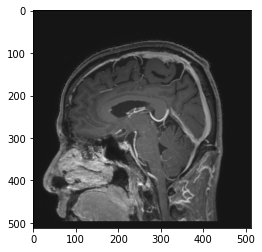

*************  25


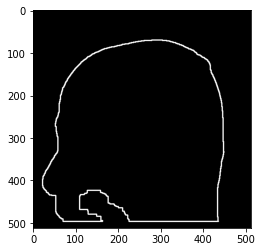

(512, 512)
(512, 512)
(512, 512)


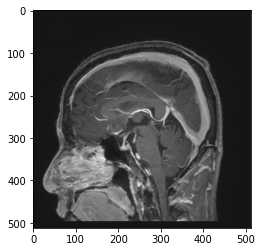

*************  26


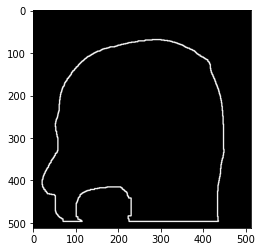

(512, 512)
(512, 512)
(512, 512)


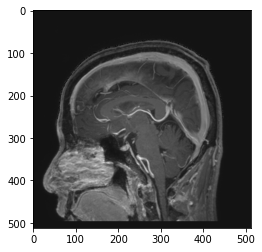

*************  27


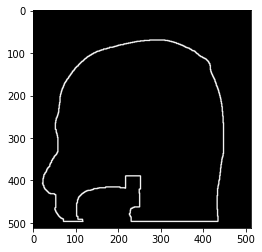

(512, 512)
(512, 512)
(512, 512)


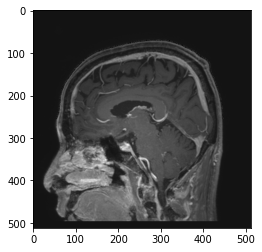

*************  28


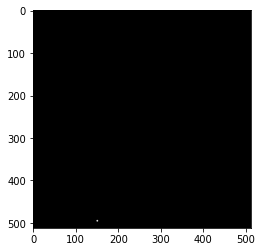

(512, 512)
(512, 512)
(512, 512)


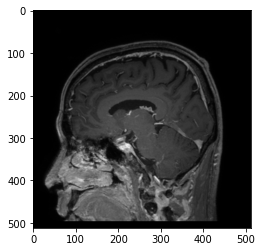

*************  29


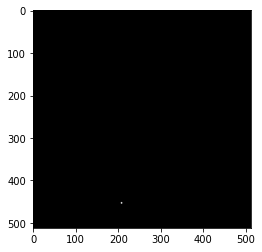

(512, 512)
(512, 512)
(512, 512)


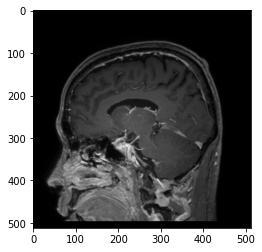

*************  30


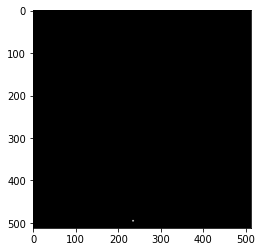

(512, 512)
(512, 512)
(512, 512)


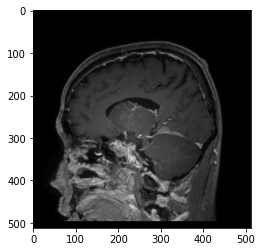

*************  31


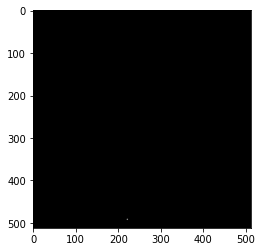

(512, 512)
(512, 512)
(512, 512)


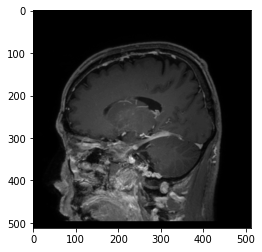

*************  32


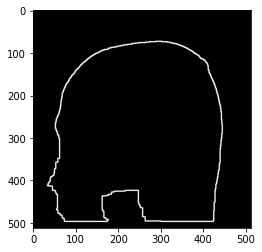

(512, 512)
(512, 512)
(512, 512)


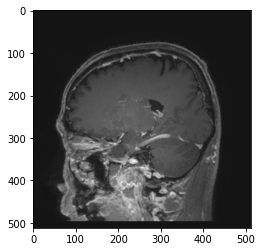

*************  33


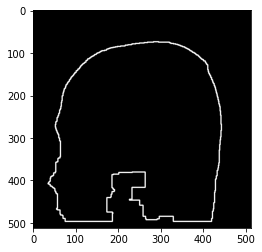

(512, 512)
(512, 512)
(512, 512)


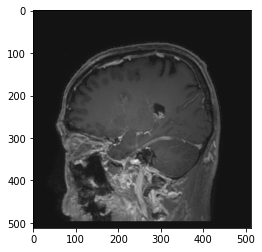

*************  34


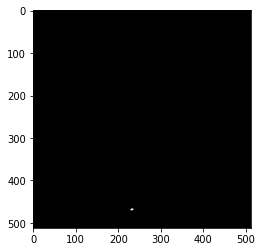

(512, 512)
(512, 512)
(512, 512)


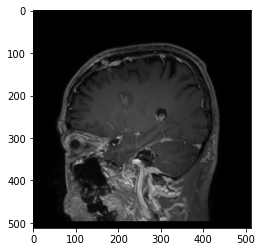

*************  35


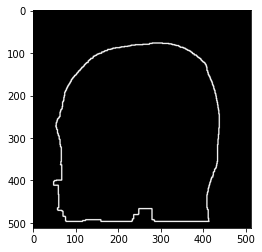

(512, 512)
(512, 512)
(512, 512)


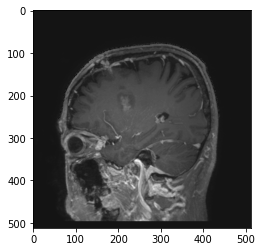

*************  36


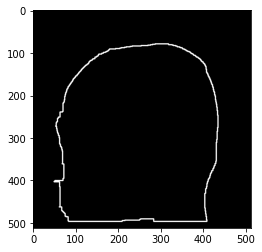

(512, 512)
(512, 512)
(512, 512)


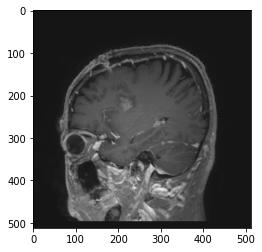

*************  37


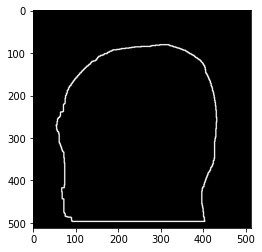

(512, 512)
(512, 512)
(512, 512)


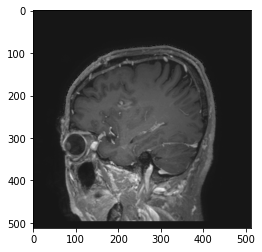

*************  38


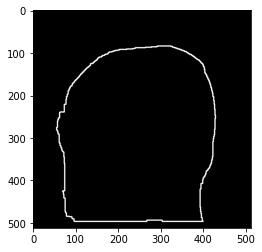

(512, 512)
(512, 512)
(512, 512)


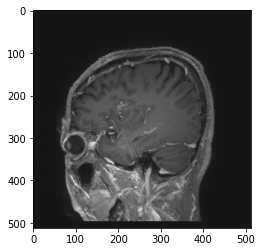

*************  39


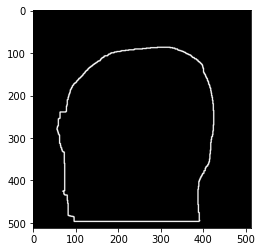

(512, 512)
(512, 512)
(512, 512)


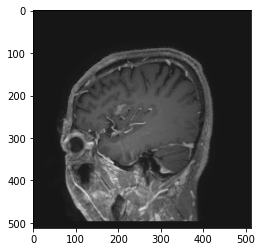

*************  40


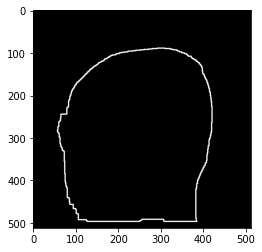

(512, 512)
(512, 512)
(512, 512)


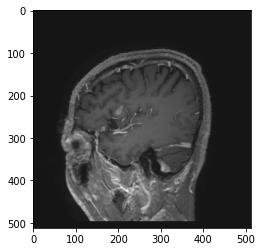

*************  41


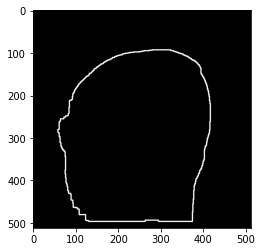

(512, 512)
(512, 512)
(512, 512)


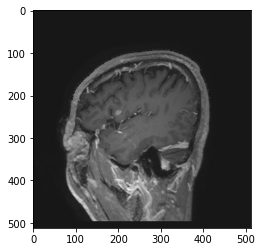

*************  42


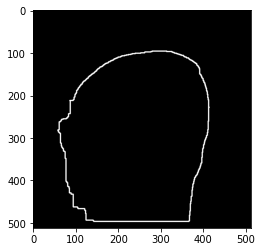

(512, 512)
(512, 512)
(512, 512)


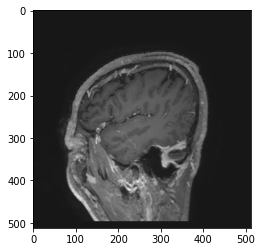

*************  43


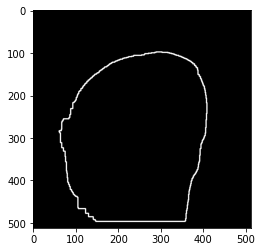

(512, 512)
(512, 512)
(512, 512)


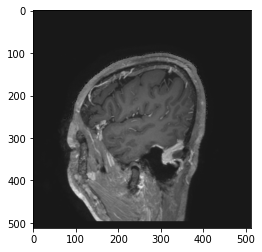

*************  44


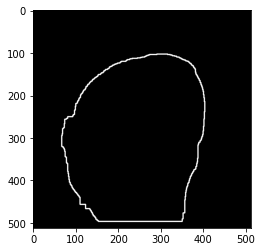

(512, 512)
(512, 512)
(512, 512)


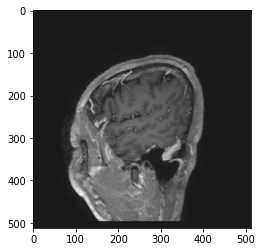

*************  45


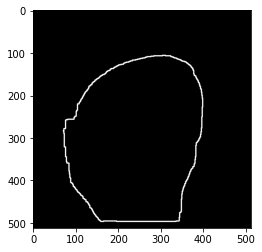

(512, 512)
(512, 512)
(512, 512)


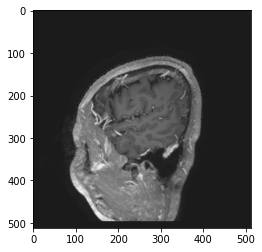

*************  46


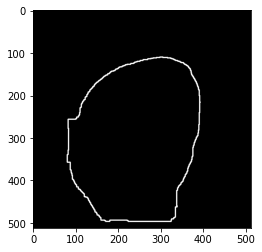

(512, 512)
(512, 512)
(512, 512)


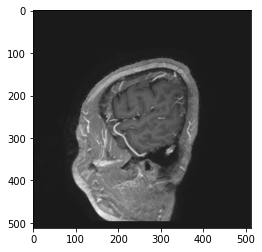

*************  47


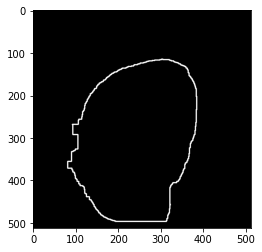

(512, 512)
(512, 512)
(512, 512)


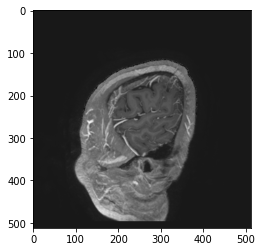

*************  48


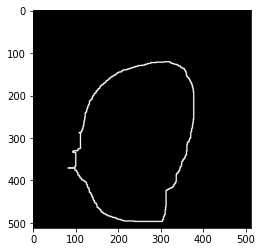

(512, 512)
(512, 512)
(512, 512)


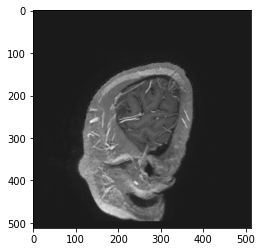

*************  49


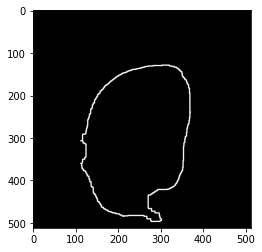

(512, 512)
(512, 512)
(512, 512)


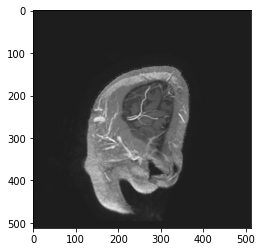

In [71]:
scan9 = np.asarray(scan_seriesi[9])
s9 = dynamic_windowing(np.asarray(scan_seriesi[9]))
for i in range(s9[0].shape[0]):
    print("************* ",i)
    out = MRI_blurred_axial(s9[0][i]*np.max(scan9[i]), scan9[i])
    plt.imshow(out,'gray')
    plt.show()

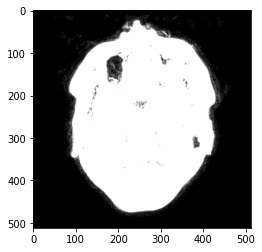

In [53]:
plt.imshow(s7[0][49],'gray')

In [56]:
s7[0][2][390][400]*np.max(scan7[2])

133.5867414869463

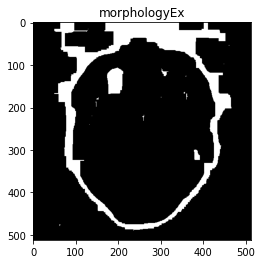

/tmp/ipykernel_21625/1364483396.py:18: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  imagee = ndimage.morphology.binary_fill_holes(imagee)


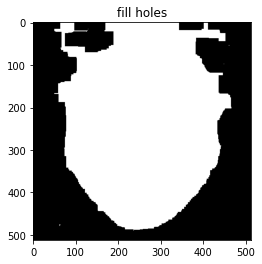

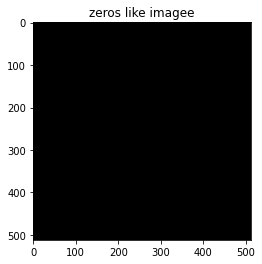

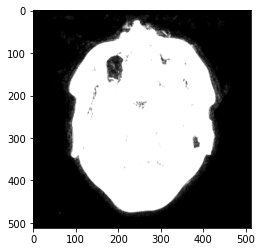

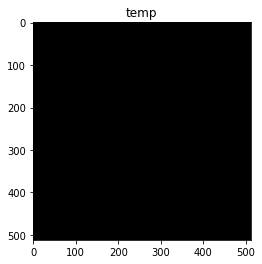

(512, 512)
(512, 512)
(512, 512)


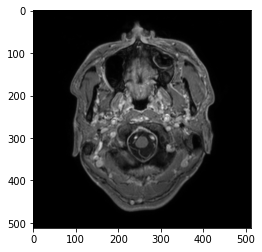

In [67]:
out = MRI_blurred_axial(s7[0][49]*np.max(scan7[49]), scan7[49])
plt.imshow(out,'gray')
plt.show()